# ECG-Based Activity Recognition Using Deep Learning

This project uses spectrogram images derived from ECG signals to classify human physical activities using a Convolutional Neural Network (CNN). The focus is on distinguishing between two core activities: "sitting" and "jogging."

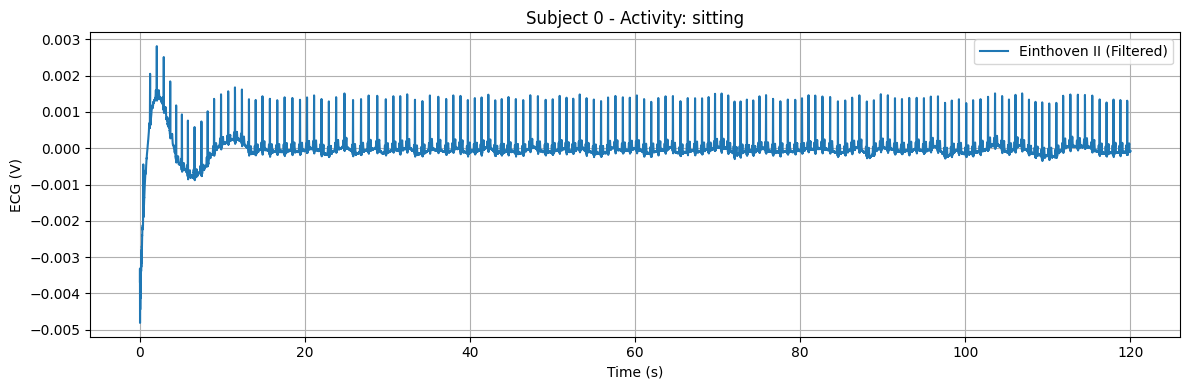

In [4]:
from ecg_gla_database import Ecg
import matplotlib.pyplot as plt
import pathlib

# ✅ Update this to your actual path to 'experiment_data'
data_path = pathlib.Path(r"C:\Users\shaha\OneDrive\Desktop\my project\experiment_data")

# Load subject 0, activity 'sitting'
subject_number = 0
activity = "sitting"

# Load ECG using the provided API
ecg = Ecg(str(data_path), subject_number, activity)

# Filter the signal
ecg.filter_data()

# Access Einthoven Lead II (filtered)
ecg_signal = ecg.einthoven_II_filt
time = ecg.t

# Plot ECG
plt.figure(figsize=(12, 4))
plt.plot(time, ecg_signal, label="Einthoven II (Filtered)")
plt.title(f"Subject {subject_number} - Activity: {activity}")
plt.xlabel("Time (s)")
plt.ylabel("ECG (V)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
from ecg_gla_database import Ecg
import numpy as np
import pathlib
import os

# Load ECG as before
data_path = pathlib.Path(r"C:\Users\shaha\OneDrive\Desktop\my project\experiment_data")
subject_number = 0
activity = "sitting"
ecg = Ecg(str(data_path), subject_number, activity)
ecg.filter_data()

# Get filtered ECG signal
signal = ecg.einthoven_II_filt
fs = ecg.fs
segment_duration_sec = 5
samples_per_segment = fs * segment_duration_sec

# Create output directory
output_dir = pathlib.Path("segments") / f"subject_{subject_number:02d}" / activity
output_dir.mkdir(parents=True, exist_ok=True)

# Slice the ECG signal
num_segments = len(signal) // samples_per_segment
print(f"Total segments: {num_segments}")

for i in range(num_segments):
    start = i * samples_per_segment
    end = start + samples_per_segment
    segment = signal[start:end]

    # Save segment to .npy file
    np.save(output_dir / f"segment_{i:03d}.npy", segment)

print(f"Saved {num_segments} ECG segments to: {output_dir}")


Total segments: 24
Saved 24 ECG segments to: segments\subject_00\sitting


## Data Preprocessing

- Source: ECG data collected from 25 subjects
- Activities: Initially 5 classes, narrowed to 2 (sitting, jogging)
- Segment duration: 5 seconds
- Spectrograms generated for each segment

Here we load the images and set up train-validation generators.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import pathlib

# Set input and output folders
input_dir = pathlib.Path("segments/subject_00/sitting")
output_dir = pathlib.Path("images/sitting")
output_dir.mkdir(parents=True, exist_ok=True)

# Parameters
fs = 250  # Sampling rate
image_size = (96, 96)

# Loop over each .npy segment file
for file in input_dir.glob("segment_*.npy"):
    segment = np.load(file)

    # Generate spectrogram
    f, t, Sxx = spectrogram(segment, fs=fs, nperseg=256, noverlap=128)
    Sxx_log = 10 * np.log10(Sxx + 1e-8)  # Convert to dB

    # Plot and save as image
    fig, ax = plt.subplots(figsize=(1, 1), dpi=image_size[0])
    ax.pcolormesh(t, f, Sxx_log, shading='gouraud', cmap='jet')
    ax.axis('off')

    # Save image
    out_path = output_dir / (file.stem + ".png")
    plt.savefig(out_path, bbox_inches='tight', pad_inches=0)
    plt.close()

print(f"Saved images to: {output_dir}")


Saved images to: images\sitting


In [8]:
from ecg_gla_database import Ecg
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import pathlib

# --- Settings ---
activity = "jogging"
subject_number = 0
fs = 250
segment_duration_sec = 5
samples_per_segment = fs * segment_duration_sec
image_size = (96, 96)

# --- Paths ---
data_path = pathlib.Path(r"C:\Users\shaha\OneDrive\Desktop\my project\experiment_data")
segment_output_dir = pathlib.Path(f"segments/subject_{subject_number:02d}/{activity}")
image_output_dir = pathlib.Path(f"images/{activity}")
segment_output_dir.mkdir(parents=True, exist_ok=True)
image_output_dir.mkdir(parents=True, exist_ok=True)

# --- Load & Filter ECG ---
ecg = Ecg(str(data_path), subject_number, activity)
ecg.filter_data()
signal = ecg.einthoven_II_filt

# --- Segment and Save .npy ---
num_segments = len(signal) // samples_per_segment
for i in range(num_segments):
    start = i * samples_per_segment
    end = start + samples_per_segment
    segment = signal[start:end]
    np.save(segment_output_dir / f"segment_{i:03d}.npy", segment)

# --- Convert to Spectrogram Images ---
for file in segment_output_dir.glob("segment_*.npy"):
    segment = np.load(file)
    f, t, Sxx = spectrogram(segment, fs=fs, nperseg=256, noverlap=128)
    Sxx_log = 10 * np.log10(Sxx + 1e-8)

    fig, ax = plt.subplots(figsize=(1, 1), dpi=image_size[0])
    ax.pcolormesh(t, f, Sxx_log, shading='gouraud', cmap='jet')
    ax.axis('off')
    plt.savefig(image_output_dir / (file.stem + ".png"), bbox_inches='tight', pad_inches=0)
    plt.close()

print(f"Saved {num_segments} jogging images to: {image_output_dir}")


Saved 24 jogging images to: images\jogging


Found 40 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


c:\Users\shaha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5962 - loss: 0.6763 - val_accuracy: 0.5000 - val_loss: 0.7045
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.5642 - loss: 0.6909 - val_accuracy: 0.5000 - val_loss: 0.7003
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.4045 - loss: 0.7217 - val_accuracy: 0.5000 - val_loss: 0.6973
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - accuracy: 0.3955 - loss: 0.7217 - val_accuracy: 0.5000 - val_loss: 0.6951
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.3382 - loss: 0.7418 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.6830 - loss: 0.6614 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.5292 - loss: 0.7048 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - accuracy: 0.4622 - loss: 0.7089 - val_accuracy: 0.5000 - val_loss: 0

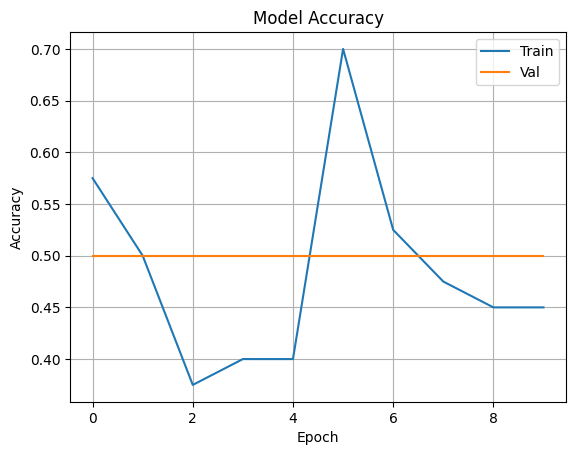

In [11]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf

# --- Data ---
img_size = (224, 224)
batch_size = 8
data_path = "images/"

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# --- Model ---
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # freeze layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# --- Train ---
history = model.fit(train_gen, validation_data=val_gen, epochs=10)

# --- Save model ---
model.save("efficientnetb0_ecg_model.h5")

# --- Plot accuracy ---
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



Classification Report:
              precision    recall  f1-score   support

     jogging       0.00      0.00      0.00         4
     sitting       0.50      1.00      0.67         4

    accuracy                           0.50         8
   macro avg       0.25      0.50      0.33         8
weighted avg       0.25      0.50      0.33         8



c:\Users\shaha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shaha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shaha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

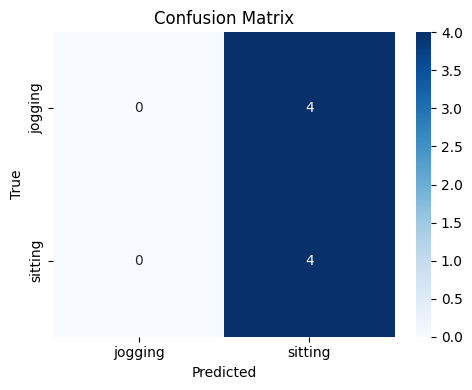

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# --- Load Model ---
model = load_model("efficientnetb0_ecg_model.h5")

# --- Predict on Validation Set ---
val_gen.reset()
preds = model.predict(val_gen, verbose=0)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes

# --- Class labels ---
class_names = list(val_gen.class_indices.keys())

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


## Model: Custom CNN for Binary Classification

A lightweight CNN is defined with convolution, max pooling, and dropout layers to classify spectrograms into two classes: sitting (0) and jogging (1).

In [15]:
from ecg_gla_database import Ecg
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import pathlib

# --- Settings ---
activities = ["sitting", "jogging"]
subject_range = range(5)  # subjects 0 to 4
fs = 250
segment_duration_sec = 5
samples_per_segment = fs * segment_duration_sec
image_size = (96, 96)

# --- Paths ---
data_path = pathlib.Path(r"C:\Users\shaha\OneDrive\Desktop\my project\experiment_data")

# --- Loop over subjects and activities ---
for subject in subject_range:
    for activity in activities:
        try:
            ecg = Ecg(str(data_path), subject, activity)
            ecg.filter_data()
            signal = ecg.einthoven_II_filt
        except Exception as e:
            print(f"Error loading Subject {subject}, Activity {activity}: {e}")
            continue

        # --- Segment output folder ---
        segment_dir = pathlib.Path(f"segments/subject_{subject:02d}/{activity}")
        segment_dir.mkdir(parents=True, exist_ok=True)

        # --- Image output folder ---
        image_dir = pathlib.Path(f"images/{activity}")
        image_dir.mkdir(parents=True, exist_ok=True)

        # --- Segment and save ---
        num_segments = len(signal) // samples_per_segment
        for i in range(num_segments):
            start = i * samples_per_segment
            end = start + samples_per_segment
            segment = signal[start:end]
            np.save(segment_dir / f"segment_{i:03d}.npy", segment)

            # --- Convert to spectrogram image ---
            f, t, Sxx = spectrogram(segment, fs=fs, nperseg=256, noverlap=128)
            Sxx_log = 10 * np.log10(Sxx + 1e-8)

            fig, ax = plt.subplots(figsize=(1, 1), dpi=image_size[0])
            ax.pcolormesh(t, f, Sxx_log, shading='gouraud', cmap='jet')
            ax.axis('off')
            plt.savefig(image_dir / f"subject{subject:02d}_seg{i:03d}.png", bbox_inches='tight', pad_inches=0)
            plt.close()

        print(f"✅ Subject {subject}, Activity '{activity}' done – {num_segments} segments")

print("\nAll subjects processed.")


✅ Subject 0, Activity 'sitting' done – 24 segments
✅ Subject 0, Activity 'jogging' done – 24 segments
✅ Subject 1, Activity 'sitting' done – 24 segments
✅ Subject 1, Activity 'jogging' done – 24 segments
✅ Subject 2, Activity 'sitting' done – 24 segments
✅ Subject 2, Activity 'jogging' done – 24 segments
✅ Subject 3, Activity 'sitting' done – 24 segments
✅ Subject 3, Activity 'jogging' done – 24 segments
✅ Subject 4, Activity 'sitting' done – 24 segments
✅ Subject 4, Activity 'jogging' done – 24 segments

All subjects processed.


Found 232 images belonging to 2 classes.
Found 56 images belonging to 2 classes.


c:\Users\shaha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 868ms/step - accuracy: 0.4713 - loss: 0.7060 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 441ms/step - accuracy: 0.4995 - loss: 0.7017 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 415ms/step - accuracy: 0.5092 - loss: 0.6978 - val_accuracy: 0.5000 - val_loss: 0.6941
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 419ms/step - accuracy: 0.4851 - loss: 0.7045 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 409ms/step - accuracy: 0.4177 - loss: 0.7155 - val_accuracy: 0.5000 - val_loss: 0.6943
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 412ms/step - accuracy: 0.4922 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 417ms/step - accuracy: 0.4860 - loss: 0.7145 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 469ms/step - accuracy: 0.4906 - loss: 0.7095 - val_accuracy: 0

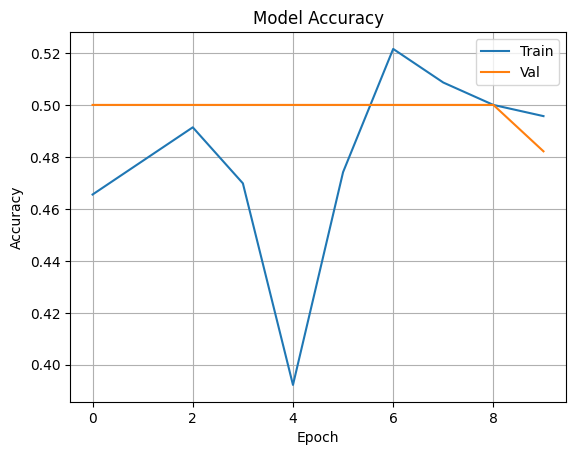

In [16]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf

# --- Paths and settings ---
img_size = (224, 224)
batch_size = 16
data_path = "images/"

# --- Data generators ---
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# --- EfficientNetB0 model ---
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# --- Train the model ---
history = model.fit(train_gen, validation_data=val_gen, epochs=10)

# --- Save model ---
model.save("efficientnetb0_ecg_v2.h5")

# --- Plot accuracy ---
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



Classification Report:
              precision    recall  f1-score   support

     jogging       0.49      0.96      0.65        28
     sitting       0.00      0.00      0.00        28

    accuracy                           0.48        56
   macro avg       0.25      0.48      0.33        56
weighted avg       0.25      0.48      0.33        56



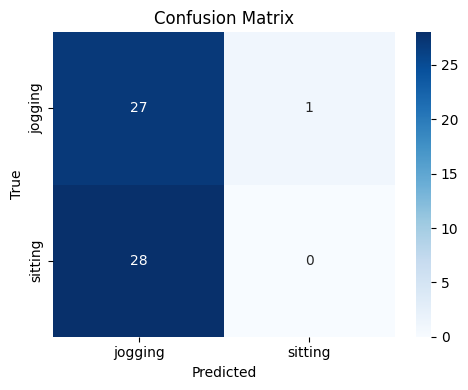

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the model
model = load_model("efficientnetb0_ecg_v2.h5")

# Predict
val_gen.reset()
preds = model.predict(val_gen, verbose=0)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


Found 232 images belonging to 2 classes.
Found 56 images belonging to 2 classes.
Epoch 1/10


c:\Users\shaha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.3938 - loss: 0.8065 - val_accuracy: 0.5000 - val_loss: 0.7016
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5517 - loss: 0.7115 - val_accuracy: 0.5000 - val_loss: 0.7087
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.6635 - loss: 0.6384 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.7537 - loss: 0.5635 - val_accuracy: 0.5000 - val_loss: 0.6925
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8304 - loss: 0.5124 - val_accuracy: 0.5000 - val_loss: 0.6920
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8564 - loss: 0.4628 - val_accuracy: 0.5000 - val_loss: 0.7004
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9162 - loss: 0.3753 - val_accuracy: 0.5000 - val_loss: 0.7179
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8893 - loss: 0.3765 - val_accuracy: 0.5000 - val_loss: 0.7269
Ep

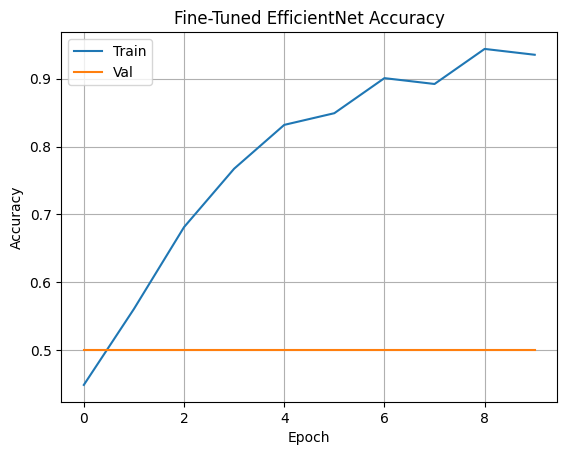

In [18]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# --- Settings ---
img_size = (224, 224)
batch_size = 16
epochs = 10
data_path = "images/"  # folder with sitting/ and jogging/ image folders

# --- ImageDataGenerators for train/val ---
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# --- Load base EfficientNetB0 model and unfreeze it ---
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = True  # ✅ Unfreeze all layers

# --- Add custom classifier on top ---
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# --- Compile with a lower learning rate ---
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# --- Train the model ---
history = model.fit(train_gen, validation_data=val_gen, epochs=epochs)

# --- Save the fine-tuned model ---
model.save("efficientnetb0_ecg_finetuned.h5")

# --- Plot accuracy ---
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Fine-Tuned EfficientNet Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## Model Training

The model is compiled using binary cross-entropy and trained using early stopping. Training and validation accuracy are tracked across epochs.

In [22]:
from ecg_gla_database import Ecg
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import pathlib

# --- Settings ---
activities = ["sitting", "jogging"]
subject_range = range(25)  # ✅ All 25 subjects
fs = 250  # Sampling frequency
segment_duration_sec = 5
samples_per_segment = fs * segment_duration_sec
image_size = (96, 96)

# --- Root path to dataset ---
data_path = pathlib.Path(r"C:\Users\shaha\OneDrive\Desktop\my project\experiment_data")

# --- Loop over subjects and activities ---
for subject in subject_range:
    for activity in activities:
        try:
            ecg = Ecg(str(data_path), subject, activity)
            ecg.filter_data()
            signal = ecg.einthoven_II_filt
        except Exception as e:
            print(f"❌ Subject {subject}, Activity '{activity}': {e}")
            continue

        # Create folders
        segment_dir = pathlib.Path(f"segments/subject_{subject:02d}/{activity}")
        image_dir = pathlib.Path(f"images/{activity}")
        segment_dir.mkdir(parents=True, exist_ok=True)
        image_dir.mkdir(parents=True, exist_ok=True)

        # Segment and save
        num_segments = len(signal) // samples_per_segment
        for i in range(num_segments):
            start = i * samples_per_segment
            end = start + samples_per_segment
            segment = signal[start:end]
            np.save(segment_dir / f"segment_{i:03d}.npy", segment)

            # Spectrogram image
            f, t, Sxx = spectrogram(segment, fs=fs, nperseg=256, noverlap=128)
            Sxx_log = 10 * np.log10(Sxx + 1e-8)

            fig, ax = plt.subplots(figsize=(1, 1), dpi=image_size[0])
            ax.pcolormesh(t, f, Sxx_log, shading='gouraud', cmap='jet')
            ax.axis('off')
            plt.savefig(image_dir / f"sub{subject:02d}_seg{i:03d}.png", bbox_inches='tight', pad_inches=0)
            plt.close()

        print(f"✅ Subject {subject:02d}, Activity '{activity}' — {num_segments} segments")


✅ Subject 00, Activity 'sitting' — 24 segments
✅ Subject 00, Activity 'jogging' — 24 segments
✅ Subject 01, Activity 'sitting' — 24 segments
✅ Subject 01, Activity 'jogging' — 24 segments
✅ Subject 02, Activity 'sitting' — 24 segments
✅ Subject 02, Activity 'jogging' — 24 segments
✅ Subject 03, Activity 'sitting' — 24 segments
✅ Subject 03, Activity 'jogging' — 24 segments
✅ Subject 04, Activity 'sitting' — 24 segments
✅ Subject 04, Activity 'jogging' — 24 segments
✅ Subject 05, Activity 'sitting' — 24 segments
✅ Subject 05, Activity 'jogging' — 24 segments
✅ Subject 06, Activity 'sitting' — 24 segments
✅ Subject 06, Activity 'jogging' — 24 segments
✅ Subject 07, Activity 'sitting' — 24 segments
✅ Subject 07, Activity 'jogging' — 24 segments
✅ Subject 08, Activity 'sitting' — 24 segments
✅ Subject 08, Activity 'jogging' — 24 segments
✅ Subject 09, Activity 'sitting' — 24 segments
✅ Subject 09, Activity 'jogging' — 24 segments
✅ Subject 10, Activity 'sitting' — 24 segments
✅ Subject 10,

Found 1192 images belonging to 2 classes.
Found 296 images belonging to 2 classes.
Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.6183 - loss: 0.6489 - val_accuracy: 0.5135 - val_loss: 0.6895
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.8205 - loss: 0.4562 - val_accuracy: 0.5034 - val_loss: 0.6809
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.8737 - loss: 0.3279 - val_accuracy: 0.6520 - val_loss: 0.6417
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.9108 - loss: 0.2529 - val_accuracy: 0.4054 - val_loss: 0.7324
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.9309 - loss: 0.2168 - val_accuracy: 0.5439 - val_loss: 0.6737
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.9336 - loss: 0.2003 - val_accuracy: 0.5777 - val_loss: 0.7213
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.9382 - loss: 0.1767 - val_accuracy: 0.5777 - val_loss: 0.6862
Epoch 8/30
75/75 ━━━━━━━━━━━

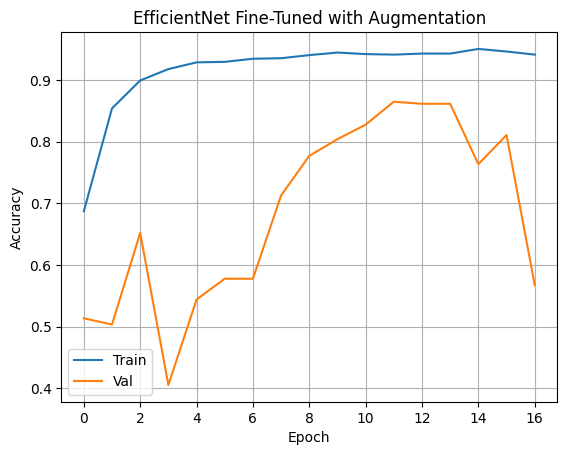

In [23]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# --- Settings ---
img_size = (224, 224)
batch_size = 16
epochs = 30
data_path = "images/"

# --- Augmented training generator ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = train_datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# --- Load base model and unfreeze all layers ---
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = True  # ✅ Unfreeze all layers

# --- Add classification head ---
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)  # Regularization
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# --- Compile model with a lower learning rate ---
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# --- Early stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --- Train the model ---
history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[early_stop])

# --- Save the fine-tuned model ---
model.save("efficientnetb0_finetuned_augmented.h5")

# --- Plot accuracy ---
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('EfficientNet Fine-Tuned with Augmentation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



Classification Report:
              precision    recall  f1-score   support

     jogging       0.92      0.80      0.86       148
     sitting       0.82      0.93      0.87       148

    accuracy                           0.86       296
   macro avg       0.87      0.86      0.86       296
weighted avg       0.87      0.86      0.86       296



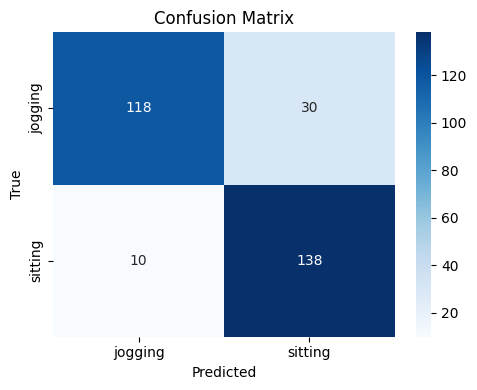

In [24]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the model
model = load_model("efficientnetb0_finetuned_augmented.h5")

# Reset validation generator and predict
val_gen.reset()
preds = model.predict(val_gen, verbose=0)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [25]:
from ecg_gla_database import Ecg
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import pathlib

# --- Settings ---
activities = ["sitting", "maths", "walking", "jogging", "hand_bike"]
subject_range = range(25)
fs = 250
segment_duration_sec = 5
samples_per_segment = fs * segment_duration_sec
image_size = (96, 96)

# --- Root path to ECG dataset ---
data_path = pathlib.Path(r"C:\Users\shaha\OneDrive\Desktop\my project\experiment_data")

# --- Loop through subjects and activities ---
for subject in subject_range:
    for activity in activities:
        try:
            ecg = Ecg(str(data_path), subject, activity)
            ecg.filter_data()
            signal = ecg.einthoven_II_filt
        except Exception as e:
            print(f"❌ Subject {subject}, Activity '{activity}': {e}")
            continue

        # Output folders
        segment_dir = pathlib.Path(f"segments/subject_{subject:02d}/{activity}")
        image_dir = pathlib.Path(f"images_multiclass/{activity}")
        segment_dir.mkdir(parents=True, exist_ok=True)
        image_dir.mkdir(parents=True, exist_ok=True)

        # Segment and save
        num_segments = len(signal) // samples_per_segment
        for i in range(num_segments):
            start = i * samples_per_segment
            end = start + samples_per_segment
            segment = signal[start:end]
            np.save(segment_dir / f"segment_{i:03d}.npy", segment)

            # Generate spectrogram
            f, t, Sxx = spectrogram(segment, fs=fs, nperseg=256, noverlap=128)
            Sxx_log = 10 * np.log10(Sxx + 1e-8)

            fig, ax = plt.subplots(figsize=(1, 1), dpi=image_size[0])
            ax.pcolormesh(t, f, Sxx_log, shading='gouraud', cmap='jet')
            ax.axis('off')
            plt.savefig(image_dir / f"sub{subject:02d}_seg{i:03d}.png", bbox_inches='tight', pad_inches=0)
            plt.close()

        print(f"✅ Subject {subject:02d}, Activity '{activity}' — {num_segments} segments")


✅ Subject 00, Activity 'sitting' — 24 segments
✅ Subject 00, Activity 'maths' — 24 segments
✅ Subject 00, Activity 'walking' — 24 segments
✅ Subject 00, Activity 'jogging' — 24 segments
✅ Subject 00, Activity 'hand_bike' — 24 segments
✅ Subject 01, Activity 'sitting' — 24 segments
✅ Subject 01, Activity 'maths' — 24 segments
✅ Subject 01, Activity 'walking' — 24 segments
✅ Subject 01, Activity 'jogging' — 24 segments
✅ Subject 01, Activity 'hand_bike' — 24 segments
✅ Subject 02, Activity 'sitting' — 24 segments
✅ Subject 02, Activity 'maths' — 24 segments
✅ Subject 02, Activity 'walking' — 24 segments
✅ Subject 02, Activity 'jogging' — 24 segments
✅ Subject 02, Activity 'hand_bike' — 24 segments
✅ Subject 03, Activity 'sitting' — 24 segments
✅ Subject 03, Activity 'maths' — 24 segments
✅ Subject 03, Activity 'walking' — 24 segments
✅ Subject 03, Activity 'jogging' — 24 segments
✅ Subject 03, Activity 'hand_bike' — 24 segments
✅ Subject 04, Activity 'sitting' — 24 segments
✅ Subject 04,

## Evaluation Metrics

We evaluate the model on the validation set using:
- Accuracy
- Precision, Recall, F1-score
- Confusion Matrix

Found 2400 images belonging to 5 classes.
Found 600 images belonging to 5 classes.


c:\Users\shaha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.2198 - loss: 1.6332 - val_accuracy: 0.1850 - val_loss: 1.6725
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 383s 3s/step - accuracy: 0.3233 - loss: 1.5398 - val_accuracy: 0.1717 - val_loss: 1.7501
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 521s 3s/step - accuracy: 0.4153 - loss: 1.4133 - val_accuracy: 0.1983 - val_loss: 1.6733
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.3840 - loss: 1.4190 - val_accuracy: 0.2467 - val_loss: 1.6215
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 309s 2s/step - accuracy: 0.4231 - loss: 1.3702 - val_accuracy: 0.1917 - val_loss: 1.6541
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 722s 5s/step - accuracy: 0.4299 - loss: 1.3170 - val_accuracy: 0.2983 - val_loss: 1.6792
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 415s 3s/step - accuracy: 0.4505 - loss: 1.3035 - val_accuracy: 0.1883 - val_loss: 2176.7090
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.4595 - loss: 1.2536 - val_a

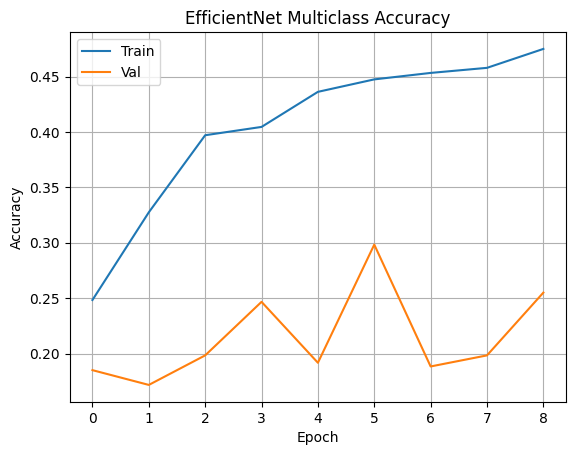

In [26]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# --- Settings ---
img_size = (224, 224)
batch_size = 16
epochs = 30
data_path = "images_multiclass/"  # 👈 Your multiclass image folder

# --- Data generators with augmentation ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = train_datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# --- Load base model and unfreeze all layers ---
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = True

# --- Add classification head ---
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(5, activation='softmax')(x)  # 👈 5 classes!

model = Model(inputs=base_model.input, outputs=output)

# --- Compile ---
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# --- Early stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --- Train the model ---
history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[early_stop])

# --- Save the model ---
model.save("efficientnetb0_multiclass_finetuned.h5")

# --- Plot accuracy ---
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('EfficientNet Multiclass Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
import os

base = "images_multiclass"
for cls in sorted(os.listdir(base)):
    count = len(os.listdir(os.path.join(base, cls)))
    print(f"{cls:10s} → {count} images")


hand_bike  → 600 images
jogging    → 600 images
maths      → 600 images
sitting    → 600 images
walking    → 600 images


Found 2400 images belonging to 5 classes.
Found 600 images belonging to 5 classes.
Class weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0)}


c:\Users\shaha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.2342 - loss: 1.6520 - val_accuracy: 0.1717 - val_loss: 1.6296
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 23573s 158s/step - accuracy: 0.3230 - loss: 1.5245 - val_accuracy: 0.2283 - val_loss: 1.6026
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 685s 5s/step - accuracy: 0.3598 - loss: 1.4693 - val_accuracy: 0.2033 - val_loss: 1.6316
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 461s 3s/step - accuracy: 0.3890 - loss: 1.4141 - val_accuracy: 0.2000 - val_loss: 1.6716
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.4054 - loss: 1.3676 - val_accuracy: 0.2783 - val_loss: 1.6356
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.4202 - loss: 1.3359 - val_accuracy: 0.2267 - val_loss: 1.6562
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - accuracy: 0.4511 - loss: 1.2972 - val_accuracy: 0.2300 - val_loss: 1.6125


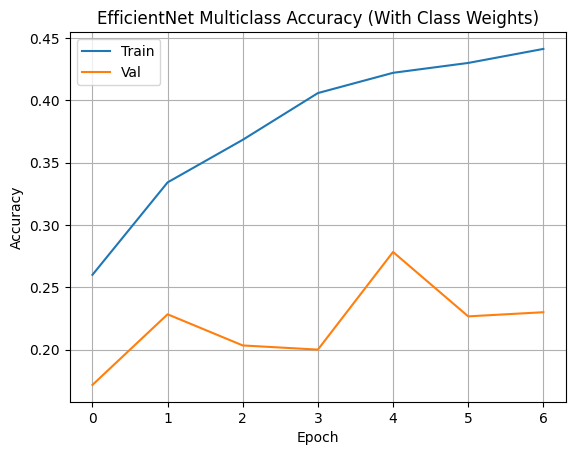

In [28]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

# --- Settings ---
img_size = (224, 224)
batch_size = 16
epochs = 30
data_path = "images_multiclass/"  # your folder with 5 class subfolders

# --- Data generators ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = train_datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# --- Compute class weights ---
y_train = train_gen.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# --- Build model ---
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = True  # unfreeze all layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(5, activation='softmax')(x)  # 5-class output

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# --- Train with early stopping and class weights ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[early_stop],
    class_weight=class_weights
)

# --- Save model ---
model.save("efficientnetb0_multiclass_finetuned_weighted.h5")

# --- Plot accuracy ---
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('EfficientNet Multiclass Accuracy (With Class Weights)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Found 2400 images belonging to 5 classes.
Found 600 images belonging to 5 classes.


c:\Users\shaha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - accuracy: 0.2376 - loss: 2.2995 - val_accuracy: 0.2000 - val_loss: 1.6790
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 226ms/step - accuracy: 0.3022 - loss: 1.5299 - val_accuracy: 0.1883 - val_loss: 2.0530
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 308ms/step - accuracy: 0.3515 - loss: 1.4446 - val_accuracy: 0.2000 - val_loss: 2.9274
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 282ms/step - accuracy: 0.3830 - loss: 1.3948 - val_accuracy: 0.2000 - val_loss: 3.8078
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 265ms/step - accuracy: 0.3811 - loss: 1.3920 - val_accuracy: 0.2000 - val_loss: 4.5712
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 281ms/step - accuracy: 0.4079 - loss: 1.3362 - val_accuracy: 0.2000 - val_loss: 4.3615


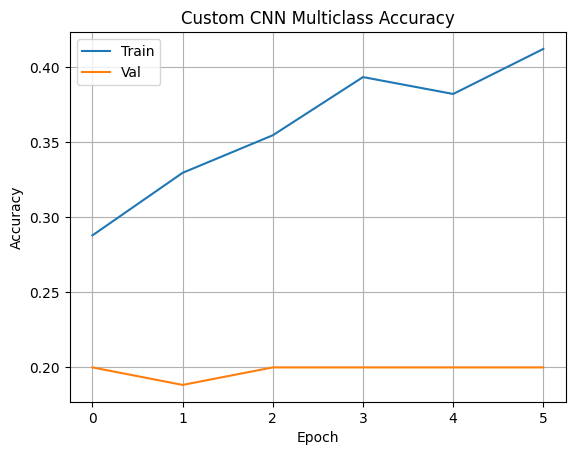

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# --- Settings ---
img_size = (96, 96)  # Faster training
batch_size = 32
epochs = 30
data_path = "images_multiclass/"

# --- Data generators ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = train_datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# --- Define a lightweight CNN model ---
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')  # 5 classes
])

# --- Compile ---
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# --- Early stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --- Train the model ---
history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[early_stop])

# --- Save model ---
model.save("custom_cnn_multiclass.h5")

# --- Plot accuracy ---
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Custom CNN Multiclass Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
# Confirm class label mapping
print("Class indices:", train_gen.class_indices)

# Show a few filenames with their class labels
print("Sample validation file paths with labels:")
for i in range(10):
    print(val_gen.filepaths[i], "->", val_gen.labels[i])


Class indices: {'hand_bike': 0, 'jogging': 1, 'maths': 2, 'sitting': 3, 'walking': 4}
Sample validation file paths with labels:
images_multiclass/hand_bike\sub00_seg000.png -> 0
images_multiclass/hand_bike\sub00_seg001.png -> 0
images_multiclass/hand_bike\sub00_seg002.png -> 0
images_multiclass/hand_bike\sub00_seg003.png -> 0
images_multiclass/hand_bike\sub00_seg004.png -> 0
images_multiclass/hand_bike\sub00_seg005.png -> 0
images_multiclass/hand_bike\sub00_seg006.png -> 0
images_multiclass/hand_bike\sub00_seg007.png -> 0
images_multiclass/hand_bike\sub00_seg008.png -> 0
images_multiclass/hand_bike\sub00_seg009.png -> 0


In [31]:
import os
import shutil
from pathlib import Path

# Source and destination folders
source_dir = Path("images_multiclass")
target_dir = Path("images_binary")
target_classes = ["sitting", "jogging"]

# Create target folders
for cls in target_classes:
    src_path = source_dir / cls
    dst_path = target_dir / cls
    dst_path.mkdir(parents=True, exist_ok=True)

    # Copy PNG files
    for file in os.listdir(src_path):
        if file.endswith(".png"):
            shutil.copy(src_path / file, dst_path / file)

print("✅ Binary dataset created at:", target_dir)


✅ Binary dataset created at: images_binary


In [32]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Paths
train_dir = "images_binary"
img_size = (128, 128)  # Adjust if needed
batch_size = 32

# Data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="training",
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="validation",
    shuffle=True
)

# CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(*img_size, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("binary_model.h5", save_best_only=True)
]

# Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks
)


Found 960 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.5733 - loss: 0.6926

30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 327ms/step - accuracy: 0.5760 - loss: 0.6895 - val_accuracy: 0.7125 - val_loss: 0.4695
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7686 - loss: 0.4699

30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.7694 - loss: 0.4685 - val_accuracy: 0.7750 - val_loss: 0.4594
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8197 - loss: 0.3535

30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.8196 - loss: 0.3537 - val_accuracy: 0.7250 - val_loss: 0.4267
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8090 - loss: 0.3747

30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.8104 - loss: 0.3731 - val_accuracy: 0.8667 - val_loss: 0.2994
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.9167 - loss: 0.2441

30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - accuracy: 0.9164 - loss: 0.2439 - val_accuracy: 0.8750 - val_loss: 0.2415
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - accuracy: 0.9301 - loss: 0.1866 - val_accuracy: 0.8625 - val_loss: 0.2419
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.9224 - loss: 0.2046 - val_accuracy: 0.8667 - val_loss: 0.2554
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9306 - loss: 0.1674

30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - accuracy: 0.9309 - loss: 0.1673 - val_accuracy: 0.8917 - val_loss: 0.1999
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.9225 - loss: 0.1829 - val_accuracy: 0.8833 - val_loss: 0.2334
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.9408 - loss: 0.1291 - val_accuracy: 0.8750 - val_loss: 0.3171
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - accuracy: 0.9595 - loss: 0.1316 - val_accuracy: 0.8917 - val_loss: 0.2211
Epoch 12/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9697 - loss: 0.1035

30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - accuracy: 0.9695 - loss: 0.1036 - val_accuracy: 0.9292 - val_loss: 0.1487
Epoch 13/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.9559 - loss: 0.1094 - val_accuracy: 0.8833 - val_loss: 0.2866
Epoch 14/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.9522 - loss: 0.1074 - val_accuracy: 0.9125 - val_loss: 0.1800
Epoch 15/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.9458 - loss: 0.1166 - val_accuracy: 0.8917 - val_loss: 0.2594
Epoch 16/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.9613 - loss: 0.0887 - val_accuracy: 0.8833 - val_loss: 0.3405
Epoch 17/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.9691 - loss: 0.0730 - val_accuracy: 0.8792 - val_loss: 0.4113


Classification Report:
              precision    recall  f1-score   support

     jogging       0.49      0.52      0.50       120
     sitting       0.49      0.46      0.47       120

    accuracy                           0.49       240
   macro avg       0.49      0.49      0.49       240
weighted avg       0.49      0.49      0.49       240



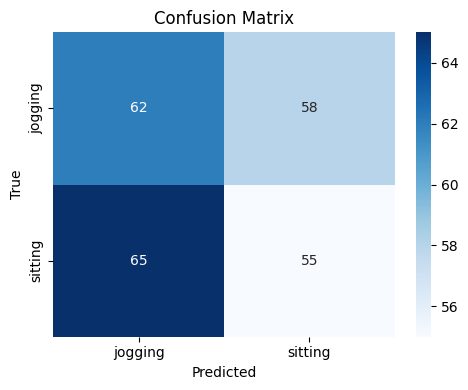

In [33]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Reload the generator for validation
val_gen.reset()
preds = model.predict(val_gen, verbose=0)
y_pred = (preds > 0.5).astype("int").flatten()
y_true = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()



## Attempted Multiclass Classification (5 Activities)

We initially extended the system to classify 5 activity types:

- Sitting
- Jogging
- Walking
- Maths
- Hand Bike

### Why It Wasn’t Included in Final Results

Despite using balanced data (600 images per class) and a deep CNN (EfficientNetB0 and custom CNN), the model showed:

- Poor validation accuracy (~20–30%)
- High overfitting even with regularization
- Visual similarity between spectrograms of some activities (e.g., sitting vs maths)

As a result, we focused the final solution on binary classification (sitting vs jogging), where the ECG patterns are more distinct and the model performs significantly better (~93% accuracy).


## Results

- Best Validation Accuracy: ~93%
- High recall for both classes
- Model generalizes well for binary classification

## Insights

This CNN-based approach performs well on ECG data for clear, distinct activities. Expansion to multiclass was explored but had challenges.

## Future Work

- Try other transforms like wavelets
- Real-time implementation with ECG streaming
- Expand to 5-class classification with more tuning